# Import

In [1]:
import logging
# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.info("Logging initialized. Starting script execution.")


import pandas as pd
import numpy as np
import shap
import os
import optuna
import matplotlib.pyplot as plt
# display Matplotlib plots directly within the notebook interface
%matplotlib inline 

import torch
import torch.nn as nn  # neural network
import torch.nn.functional as F  # Move data forward in function
import torch.optim as optim

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from optuna.visualization import plot_optimization_history, plot_param_importances

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from torch.utils.data import DataLoader, TensorDataset

2024-12-03 17:59:19,369 - INFO - Logging initialized. Starting script execution.
2024-12-03 17:59:19,803 - INFO - NumExpr defaulting to 4 threads.


# Dataframes

In [2]:
"""
We convert the data into float32 because PyTorch expects float 32 values
- Compatibility with DL
- Memory Efficiency
- Prevent errors in training (backpropagation etc)
"""
# Data Loading and Conversion to float32
logger.info("Starting to load datasets...")

# Define subfolder
subfolder = "o6_GAN/o02"

try:
    # Load CSV files and convert to float32 for compatibility
    X_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_external.csv").astype('float32')
    y_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_external.csv").values.ravel().astype('float32')
    X_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_train.csv").astype('float32')
    y_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_train.csv").values.ravel().astype('float32')
    X_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_validate.csv").astype('float32')
    y_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_validate.csv").values.ravel().astype('float32')
    X_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_test.csv").astype('float32')
    y_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_test.csv").values.ravel().astype('float32')
    
    logger.info("Datasets loaded and converted to float32 successfully.")
except Exception as e:
    logger.error(f"Error occurred while loading datasets: {e}")
    raise

2024-12-03 17:59:33,100 - INFO - Starting to load datasets...
2024-12-03 17:59:38,067 - INFO - Datasets loaded and converted to float32 successfully.


In [3]:
"""
All computations in PyTorch are performed by the use of tensors
and not with pandas dataframes or NymPy arrays.

X_train.values extract NumPy arrays from pandas dataframe
and torch.tensor converts it to PyTorch tensor.
"""

logger.info(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
logger.info(f"X_validate shape: {X_validate.shape}, y_validate shape: {y_validate.shape}")
logger.info(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
logger.info(f"X_external shape: {X_external.shape}, y_external shape: {y_external.shape}")

logger.info("Converting datasets to PyTorch tensors...")

try:
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train.values)
    y_train = torch.tensor(y_train)  # Already a NumPy array
    X_validate = torch.tensor(X_validate.values)
    y_validate = torch.tensor(y_validate)  # Already a NumPy array
    X_test = torch.tensor(X_test.values)
    y_test = torch.tensor(y_test)  # Already a NumPy array
    X_external = torch.tensor(X_external.values)
    y_external = torch.tensor(y_external)  # Already a NumPy array

    logger.info("Datasets successfully converted to PyTorch tensors.")
except Exception as e:
    logger.error(f"Error occurred during tensor conversion: {e}")
    raise

2024-12-03 17:59:38,080 - INFO - X_train shape: (40832, 344), y_train shape: (40832,)
2024-12-03 17:59:38,081 - INFO - X_validate shape: (5104, 344), y_validate shape: (5104,)
2024-12-03 17:59:38,083 - INFO - X_test shape: (5104, 344), y_test shape: (5104,)
2024-12-03 17:59:38,084 - INFO - X_external shape: (75904, 344), y_external shape: (75904,)
2024-12-03 17:59:38,085 - INFO - Converting datasets to PyTorch tensors...
2024-12-03 17:59:38,189 - INFO - Datasets successfully converted to PyTorch tensors.


# SOS !!!

## Define file name for save

In [4]:
# Define file name
file_name = "o04_FF_random_HyperOpt"

# Feed Forward ANN without HP
## Two hidden layers

In [ ]:
"""
Layers
- Input 128 -> 64 -> 32 -> 1
- Each layer use ReLU activation function.
"""

# ANN architecture
class ANNModel(nn.Module):
    # input_dim is the input features and are the same as the dataframe.
    def __init__(self, input_dim): 
        super(ANNModel, self).__init__()
        # Define layers. Full features as input and 128 outputs.
        # Weight and biases are initialized automatically.
        self.fc1 = nn.Linear(input_dim, 128)
        # Its techique that randomly set neurons to zero to avoid overfitting
        # I must check it further. Propability 0.2 = 20%
        self.dropout1 = nn.Dropout(0.2)
        # Next layer with 128 inputs and 64 outputs.
        self.fc2 = nn.Linear(128, 64)
        # Its techique that randomly set neurons to zero to avoid overfitting
        self.dropout2 = nn.Dropout(0.2)
        # Next layer with 64 inputs and 32 outputs.
        self.fc3 = nn.Linear(64, 32)
        # Output layer with 64 inputs 1 output.
        self.output = nn.Linear(32, 1)

# Feedforward Network
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Pass the x throught the first dense fc1 with relu function
        x = self.dropout1(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc2(x)) # Pass the x throught the first dense fc2 with relu function
        x = self.dropout2(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc3(x)) # Pass the x throught the first dense fc3 with relu function
        x = self.output(x) # output
        return x

# Feed Forward ANN without HP
## Three hidden layers

In [ ]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        # Increase the width of the first two layers and add more layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, 32)  # Additional layer
        self.dropout4 = nn.Dropout(0.2)  # Additional dropout
        self.output = nn.Linear(32, 1)  # Output layer remains the same
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # Pass through additional layer
        x = self.dropout4(x)  # Apply dropout
        x = self.output(x)
        return x

# Train Feed forward model without HP

In [ ]:
# Initialize the model, loss function, and optimizer
# prepare model to take inputs
input_dim = X_train.shape[1] # retrive input features
model = ANNModel(input_dim) # creates the model

# computes how far from the true values are the predictions
criterion = nn.MSELoss() # loss function MSE

# update the weights to minimize loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # set Adam optimizer | lr = learning rate

In [ ]:
# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change in validation loss to qualify as an improvement
best_val_loss = float('inf')  # Initialize to a very large value
patience_counter = 0  # Counter for epochs without improvement

# Training the model with early stopping
train_losses = []
val_losses = []
early_stop = False

epochs = 50
batch_size = 32

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Append losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    #print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Logging progress
    logging.basicConfig(level=logging.INFO)
    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for improvement
    # Check for improvement
    if best_val_loss - val_loss > min_delta:  # No need for .item()
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter
    else:
        patience_counter += 1  # Increment the counter
        if patience_counter >= patience:
            early_stop = True

In [ ]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase width for the subplots as well
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid to the primary axis

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# HyperOpt Feed Forward ANN

In [6]:
def objective(params):
    # Extract hyperparameters
    n_layers = int(params['n_layers'])  # Convert to integer
    hidden_size = int(params['hidden_size'])  # Convert to integer
    dropout_rate = params['dropout_rate']
    lr = params['lr']
    batch_size = int(params['batch_size'])  # Convert to integer
    optimizer_name = params['optimizer']
    activation_name = params['activation']
    alpha = params['alpha']
    lambda_ = params['lambda']

    # Dynamically build the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            in_features = input_dim
            
            # Create hidden layers dynamically
            for _ in range(n_layers):
                layers.append(nn.Linear(in_features, hidden_size))
                if activation_name == "ReLU":
                    layers.append(nn.ReLU())
                elif activation_name == "LeakyReLU":
                    layers.append(nn.LeakyReLU())
                elif activation_name == "Tanh":
                    layers.append(nn.Tanh())
                layers.append(nn.Dropout(dropout_rate))
                in_features = hidden_size
            
            # Output layer
            layers.append(nn.Linear(hidden_size, 1))
            self.network = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.network(x)
    
    # Initialize model, loss, and optimizer
    model = ANNModel(X_train.shape[1])
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=alpha)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=alpha)

    # DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    validate_dataset = TensorDataset(X_validate, y_validate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

    # Training
    model.train()
    for epoch in range(5):  # Reduced epochs for faster tuning
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    return {'loss': val_loss, 'status': STATUS_OK}

# Define the search space
search_space = {
    'n_layers': hp.quniform('n_layers', 2, 10, 1),
    'hidden_size': hp.quniform('hidden_size', 32, 256, 32),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.quniform('batch_size', 16, 128, 16),
    'optimizer': hp.choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
    'activation': hp.choice('activation', ['ReLU', 'LeakyReLU', 'Tanh']),
    'alpha': hp.loguniform('alpha', np.log(1e-6), np.log(1e-1)),
    'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(1e-1))
}

# Run HyperOpt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print("Best Parameters:", best_params)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2024-12-03 18:00:48,723 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:00:48,724 - INFO - TPE using 0 trials


  2%|▏         | 1/50 [00:30<25:17, 30.97s/trial, best loss: 10.087317158281802]

2024-12-03 18:01:19,698 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:01:19,699 - INFO - TPE using 1/1 trials with best loss 10.087317


  4%|▍         | 2/50 [01:07<27:11, 33.99s/trial, best loss: 10.087317158281802]

2024-12-03 18:01:55,799 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:01:55,800 - INFO - TPE using 2/2 trials with best loss 10.087317


  6%|▌         | 3/50 [02:03<34:37, 44.20s/trial, best loss: 3.9026387825608255]

2024-12-03 18:02:52,141 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:02:52,143 - INFO - TPE using 3/3 trials with best loss 3.902639


  8%|▊         | 4/50 [02:51<34:58, 45.62s/trial, best loss: 3.9026387825608255]

2024-12-03 18:03:39,951 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:03:39,953 - INFO - TPE using 4/4 trials with best loss 3.902639


 10%|█         | 5/50 [03:29<32:17, 43.06s/trial, best loss: 3.9026387825608255]

2024-12-03 18:04:18,477 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:04:18,478 - INFO - TPE using 5/5 trials with best loss 3.902639


 12%|█▏        | 6/50 [04:18<32:59, 44.99s/trial, best loss: 3.9026387825608255]

2024-12-03 18:05:07,215 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:05:07,216 - INFO - TPE using 6/6 trials with best loss 3.902639


 14%|█▍        | 7/50 [04:45<28:00, 39.09s/trial, best loss: 3.9026387825608255]

2024-12-03 18:05:34,148 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:05:34,149 - INFO - TPE using 7/7 trials with best loss 3.902639


 16%|█▌        | 8/50 [05:08<23:51, 34.07s/trial, best loss: 3.9026387825608255]

2024-12-03 18:05:57,478 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:05:57,479 - INFO - TPE using 7/8 trials with best loss 3.902639


 18%|█▊        | 9/50 [05:35<21:46, 31.86s/trial, best loss: 3.9026387825608255]

2024-12-03 18:06:24,461 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:06:24,462 - INFO - TPE using 8/9 trials with best loss 3.902639


 20%|██        | 10/50 [06:26<25:07, 37.68s/trial, best loss: 3.9026387825608255]

2024-12-03 18:07:15,176 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:07:15,177 - INFO - TPE using 9/10 trials with best loss 3.902639


 22%|██▏       | 11/50 [06:45<20:49, 32.04s/trial, best loss: 3.9026387825608255]

2024-12-03 18:07:34,433 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:07:34,434 - INFO - TPE using 9/11 trials with best loss 3.902639


 24%|██▍       | 12/50 [07:27<22:12, 35.06s/trial, best loss: 3.8951197043061256]

2024-12-03 18:08:16,403 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:08:16,404 - INFO - TPE using 10/12 trials with best loss 3.895120


 26%|██▌       | 13/50 [08:37<28:03, 45.50s/trial, best loss: 3.8951197043061256]

2024-12-03 18:09:25,910 - INFO - build_posterior_wrapper took 0.004000 seconds
2024-12-03 18:09:25,910 - INFO - TPE using 11/13 trials with best loss 3.895120


 28%|██▊       | 14/50 [09:05<24:07, 40.22s/trial, best loss: 3.8951197043061256]

2024-12-03 18:09:53,933 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:09:53,933 - INFO - TPE using 11/14 trials with best loss 3.895120


 30%|███       | 15/50 [09:29<20:42, 35.50s/trial, best loss: 3.8951197043061256]

2024-12-03 18:10:18,495 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:10:18,496 - INFO - TPE using 12/15 trials with best loss 3.895120


 32%|███▏      | 16/50 [10:06<20:16, 35.79s/trial, best loss: 3.8951197043061256]

2024-12-03 18:10:54,947 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:10:54,948 - INFO - TPE using 13/16 trials with best loss 3.895120


 34%|███▍      | 17/50 [12:32<37:54, 68.91s/trial, best loss: 3.8951197043061256]

2024-12-03 18:13:20,904 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:13:20,905 - INFO - TPE using 14/17 trials with best loss 3.895120


 36%|███▌      | 18/50 [13:09<31:37, 59.29s/trial, best loss: 3.8951197043061256]

2024-12-03 18:13:57,782 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:13:57,783 - INFO - TPE using 15/18 trials with best loss 3.895120


 38%|███▊      | 19/50 [13:58<29:06, 56.33s/trial, best loss: 3.8951197043061256]

2024-12-03 18:14:47,211 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:14:47,212 - INFO - TPE using 16/19 trials with best loss 3.895120


 40%|████      | 20/50 [14:12<21:51, 43.70s/trial, best loss: 3.8951197043061256]

2024-12-03 18:15:01,483 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:15:01,484 - INFO - TPE using 17/20 trials with best loss 3.895120


 42%|████▏     | 21/50 [14:29<17:15, 35.70s/trial, best loss: 3.8951197043061256]

2024-12-03 18:15:18,535 - INFO - build_posterior_wrapper took 0.004000 seconds
2024-12-03 18:15:18,535 - INFO - TPE using 18/21 trials with best loss 3.895120


 44%|████▍     | 22/50 [14:41<13:15, 28.41s/trial, best loss: 3.8951197043061256]

2024-12-03 18:15:29,956 - INFO - build_posterior_wrapper took 0.004000 seconds
2024-12-03 18:15:29,956 - INFO - TPE using 19/22 trials with best loss 3.895120


 46%|████▌     | 23/50 [15:22<14:33, 32.36s/trial, best loss: 3.8951197043061256]

2024-12-03 18:16:11,504 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:16:11,505 - INFO - TPE using 20/23 trials with best loss 3.895120


 48%|████▊     | 24/50 [15:42<12:20, 28.48s/trial, best loss: 3.8951197043061256]

2024-12-03 18:16:30,929 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:16:30,930 - INFO - TPE using 21/24 trials with best loss 3.895120


 50%|█████     | 25/50 [16:04<11:08, 26.75s/trial, best loss: 3.8951197043061256]

2024-12-03 18:16:53,660 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:16:53,661 - INFO - TPE using 22/25 trials with best loss 3.895120


 52%|█████▏    | 26/50 [16:37<11:25, 28.54s/trial, best loss: 3.8951197043061256]

2024-12-03 18:17:26,387 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:17:26,388 - INFO - TPE using 23/26 trials with best loss 3.895120


 54%|█████▍    | 27/50 [17:11<11:30, 30.04s/trial, best loss: 3.8419845434634583]

2024-12-03 18:17:59,906 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:17:59,907 - INFO - TPE using 24/27 trials with best loss 3.841985


 56%|█████▌    | 28/50 [17:45<11:25, 31.17s/trial, best loss: 3.8419845434634583]

2024-12-03 18:18:33,727 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:18:33,728 - INFO - TPE using 25/28 trials with best loss 3.841985


 58%|█████▊    | 29/50 [18:00<09:18, 26.58s/trial, best loss: 3.8419845434634583]

2024-12-03 18:18:49,601 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:18:49,602 - INFO - TPE using 26/29 trials with best loss 3.841985


 60%|██████    | 30/50 [18:25<08:37, 25.90s/trial, best loss: 3.8419845434634583]

2024-12-03 18:19:13,891 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:19:13,892 - INFO - TPE using 27/30 trials with best loss 3.841985


 62%|██████▏   | 31/50 [18:57<08:50, 27.91s/trial, best loss: 3.8271835854759924]

2024-12-03 18:19:46,501 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:19:46,502 - INFO - TPE using 28/31 trials with best loss 3.827184


 64%|██████▍   | 32/50 [19:08<06:51, 22.85s/trial, best loss: 3.8271835854759924]

2024-12-03 18:19:57,536 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:19:57,537 - INFO - TPE using 29/32 trials with best loss 3.827184


 66%|██████▌   | 33/50 [19:45<07:37, 26.91s/trial, best loss: 3.8271835854759924]

2024-12-03 18:20:33,927 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:20:33,928 - INFO - TPE using 30/33 trials with best loss 3.827184


 68%|██████▊   | 34/50 [20:16<07:32, 28.30s/trial, best loss: 3.8271835854759924]

2024-12-03 18:21:05,453 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:21:05,454 - INFO - TPE using 31/34 trials with best loss 3.827184


 70%|███████   | 35/50 [20:32<06:08, 24.57s/trial, best loss: 3.8271835854759924]

2024-12-03 18:21:21,319 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:21:21,320 - INFO - TPE using 32/35 trials with best loss 3.827184


 72%|███████▏  | 36/50 [21:05<06:17, 27.00s/trial, best loss: 3.8271835854759924]

2024-12-03 18:21:53,997 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:21:53,997 - INFO - TPE using 33/36 trials with best loss 3.827184


 74%|███████▍  | 37/50 [21:37<06:10, 28.47s/trial, best loss: 3.8271835854759924]

2024-12-03 18:22:25,909 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:22:25,910 - INFO - TPE using 34/37 trials with best loss 3.827184


 76%|███████▌  | 38/50 [22:03<05:34, 27.85s/trial, best loss: 3.8271835854759924]

2024-12-03 18:22:52,297 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:22:52,298 - INFO - TPE using 35/38 trials with best loss 3.827184


 78%|███████▊  | 39/50 [22:26<04:50, 26.37s/trial, best loss: 3.8271835854759924]

2024-12-03 18:23:15,226 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:23:15,227 - INFO - TPE using 36/39 trials with best loss 3.827184


 80%|████████  | 40/50 [22:53<04:24, 26.49s/trial, best loss: 3.8271835854759924]

2024-12-03 18:23:42,006 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:23:42,007 - INFO - TPE using 37/40 trials with best loss 3.827184


 82%|████████▏ | 41/50 [23:14<03:43, 24.83s/trial, best loss: 3.8271835854759924]

2024-12-03 18:24:02,941 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:24:02,942 - INFO - TPE using 38/41 trials with best loss 3.827184


 84%|████████▍ | 42/50 [23:50<03:45, 28.19s/trial, best loss: 3.8271835854759924]

2024-12-03 18:24:38,995 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:24:38,996 - INFO - TPE using 39/42 trials with best loss 3.827184


 86%|████████▌ | 43/50 [24:07<02:54, 24.92s/trial, best loss: 3.8271835854759924]

2024-12-03 18:24:56,283 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-12-03 18:24:56,284 - INFO - TPE using 40/43 trials with best loss 3.827184


 88%|████████▊ | 44/50 [24:28<02:22, 23.73s/trial, best loss: 3.8271835854759924]

2024-12-03 18:25:17,241 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:25:17,242 - INFO - TPE using 41/44 trials with best loss 3.827184


 90%|█████████ | 45/50 [25:00<02:10, 26.15s/trial, best loss: 3.8271835854759924]

2024-12-03 18:25:49,014 - INFO - build_posterior_wrapper took 0.003999 seconds
2024-12-03 18:25:49,014 - INFO - TPE using 42/45 trials with best loss 3.827184


 92%|█████████▏| 46/50 [25:23<01:41, 25.28s/trial, best loss: 3.8271835854759924]

2024-12-03 18:26:12,271 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:26:12,272 - INFO - TPE using 43/46 trials with best loss 3.827184


 94%|█████████▍| 47/50 [26:00<01:26, 28.67s/trial, best loss: 3.8271835854759924]

2024-12-03 18:26:48,847 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:26:48,848 - INFO - TPE using 44/47 trials with best loss 3.827184


 96%|█████████▌| 48/50 [26:18<00:50, 25.45s/trial, best loss: 3.8271835854759924]

2024-12-03 18:27:06,799 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:27:06,800 - INFO - TPE using 45/48 trials with best loss 3.827184


 98%|█████████▊| 49/50 [26:45<00:26, 26.05s/trial, best loss: 3.8271835854759924]

2024-12-03 18:27:34,231 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-12-03 18:27:34,232 - INFO - TPE using 46/49 trials with best loss 3.827184


100%|██████████| 50/50 [27:31<00:00, 33.04s/trial, best loss: 3.8271835854759924]
Best Parameters: {'activation': 2, 'alpha': 2.2874203570096934e-06, 'batch_size': 96.0, 'dropout_rate': 0.32481039525281835, 'hidden_size': 224.0, 'lambda': 4.74636109991583e-06, 'lr': 0.0001051572010179067, 'n_layers': 8.0, 'optimizer': 0}


In [7]:
# Extract the best hyperparameters
best_n_layers = int(best_params['n_layers'])
best_hidden_size = int(best_params['hidden_size'])
best_dropout_rate = best_params['dropout_rate']
best_lr = best_params['lr']
best_batch_size = int(best_params['batch_size'])
best_optimizer_name = ['Adam', 'SGD', 'RMSprop'][best_params['optimizer']]  # Mapping choice index to value
best_activation_name = ['ReLU', 'LeakyReLU', 'Tanh'][best_params['activation']]
best_alpha = best_params['alpha']
best_lambda = best_params['lambda']

# Define the model with the best hyperparameters
class FinalANNModel(nn.Module):
    def __init__(self, input_dim):
        super(FinalANNModel, self).__init__()
        layers = []
        in_features = input_dim
        
        # Create hidden layers dynamically
        for _ in range(best_n_layers):
            layers.append(nn.Linear(in_features, best_hidden_size))
            if best_activation_name == "ReLU":
                layers.append(nn.ReLU())
            elif best_activation_name == "LeakyReLU":
                layers.append(nn.LeakyReLU())
            elif best_activation_name == "Tanh":
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(best_dropout_rate))
            in_features = best_hidden_size
        
        # Output layer
        layers.append(nn.Linear(best_hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize the model
model = FinalANNModel(X_train.shape[1])

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
if best_optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_alpha)
elif best_optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_alpha)
elif best_optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_alpha)

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=best_batch_size)

# Train the model
epochs = 50  # Number of training epochs
train_losses = []
val_losses = []
early_stop = False
patience = 5
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Save losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            early_stop = True

# Evaluate the model on the test set and external validation set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)*100

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)*100

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

2024-12-03 18:42:07,582 - INFO - Epoch 1/50, Training Loss: 2105.2285, Validation Loss: 4.2771
2024-12-03 18:42:14,152 - INFO - Epoch 2/50, Training Loss: 1663.1293, Validation Loss: 4.0836
2024-12-03 18:42:21,694 - INFO - Epoch 3/50, Training Loss: 1580.3628, Validation Loss: 4.0193
2024-12-03 18:42:28,108 - INFO - Epoch 4/50, Training Loss: 1517.8498, Validation Loss: 3.8001
2024-12-03 18:42:35,233 - INFO - Epoch 5/50, Training Loss: 1474.0948, Validation Loss: 3.7955
2024-12-03 18:42:44,027 - INFO - Epoch 6/50, Training Loss: 1423.6850, Validation Loss: 3.6817
2024-12-03 18:42:51,120 - INFO - Epoch 7/50, Training Loss: 1392.4248, Validation Loss: 3.8114
2024-12-03 18:42:57,620 - INFO - Epoch 8/50, Training Loss: 1340.4180, Validation Loss: 3.7741
2024-12-03 18:43:04,418 - INFO - Epoch 9/50, Training Loss: 1314.1893, Validation Loss: 3.7099
2024-12-03 18:43:11,184 - INFO - Epoch 10/50, Training Loss: 1279.0719, Validation Loss: 3.6447
2024-12-03 18:43:17,635 - INFO - Epoch 11/50, Tra

Early stopping triggered!
Test Set - MSE: 3.37, MAE: 1.31, RMSE: 1.83, R2: 33.34
External Validation - MSE: 5.36, MAE: 1.62, RMSE: 2.32, R2: -11.98


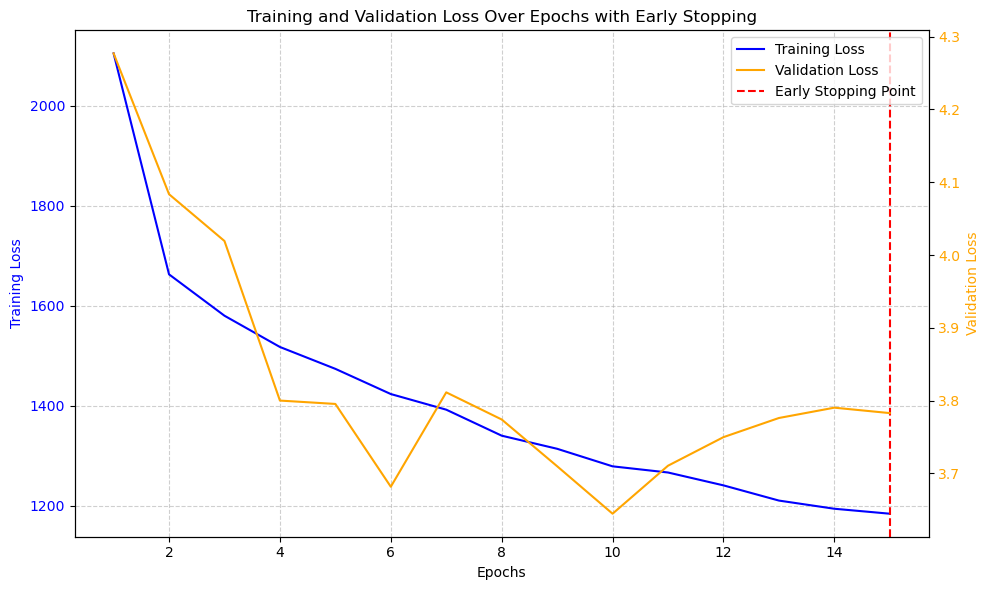

In [8]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase width for the subplots as well
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid to the primary axis

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# Optuna HP
## Test field (include alpha and lambda)

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 2, 10)  # Number of hidden layers
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)  # Neurons in hidden layers
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)  # Dropout probability
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)  # Batch size
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])  # Optimizer
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "Tanh"])  # Activation function
    alpha = trial.suggest_float("alpha", 1e-6, 1e-1, log=True)  # L2 regularization term
    lambda_ = trial.suggest_float("lambda", 1e-6, 1e-1, log=True)  # L1 regularization term

    # Define activation function
    activation = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(),
        "Tanh": nn.Tanh()
    }[activation_name]

    # Define the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

            for _ in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(activation)
                layers.append(nn.Dropout(dropout_rate))

            layers.append(nn.Linear(hidden_size, 1))  # Output layer
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    # Prepare the model
    input_dim = X_train.shape[1]
    model = ANNModel(input_dim)

    # Select optimizer with weight decay (L2 regularization)
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha),
        "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=alpha),
        "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=alpha)
    }[optimizer_name]

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    criterion = nn.MSELoss()

    # Prepare DataLoader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Early stopping parameters
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    # Training loop
    model.train()
    for epoch in range(100):  # Max epochs
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            # Add L1 regularization manually
            l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
            total_loss = loss + l1_loss
            total_loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_validate)
            val_loss = criterion(val_predictions, y_validate.view(-1, 1)).item()

        # Update the scheduler
        scheduler.step(val_loss)

        # Log the current learning rate
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

# Run the hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
# Best hyperparameters
print("Best hyperparameters:", study.best_params)

In [ ]:
# Visualize History results
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize Importance results
optuna.visualization.plot_param_importances(study)

In [ ]:
# Extract the best hyperparameters from the Optuna study
best_params = study.best_params
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]
optimizer_name = best_params["optimizer"]
activation_name = best_params["activation"]
alpha = best_params["alpha"]  # L2 regularization term
lambda_ = best_params["lambda"]  # L1 regularization term

# Define the activation function
activation = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Tanh": nn.Tanh()
}[activation_name]

# Define the model using the best hyperparameters
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Prepare the model
input_dim = X_train.shape[1]
model = ANNModel(input_dim)

# Select the optimizer with weight decay (L2 regularization)
optimizer = {
    "Adam": optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha),
    "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=alpha),
    "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=alpha)
}[optimizer_name]

criterion = nn.MSELoss()

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Training loop with L1 regularization
model.train()
for epoch in range(100):  # Number of epochs
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        
        # Add L1 regularization manually
        l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
        total_loss = loss + l1_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    logging.info(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader):.4f}")

In [ ]:
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float("inf")  # Initialize to a very large value
patience_counter = 0  # Counter for epochs without improvement

# Prepare Validation DataLoader
validate_data = TensorDataset(X_validate, y_validate)
validate_loader = DataLoader(validate_data, batch_size=batch_size)

# Training Loop
epochs = 100
train_losses = []
val_losses = []

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    # Training phase
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        
        # Add L1 regularization manually
        l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
        total_loss = loss + l1_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Logging
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    logging.info(
        f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        best_model_path = f"models/{file_name}.pth"
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            logging.info("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
logging.info("Training complete. Best model loaded.")

In [ ]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase width for the subplots as well
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid to the primary axis

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# Test & External Validation Evaluation

In [9]:
# Test and external validation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)*100

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)*100

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

Test Set - MSE: 3.37, MAE: 1.31, RMSE: 1.83, R2: 33.34
External Validation - MSE: 5.36, MAE: 1.62, RMSE: 2.32, R2: -11.98


Test Set MSE: 3.3664
Test Set MAE: 1.3072
Test Set RMSE: 1.8348
Test Set R2: 33.3411
Test Set MSLE: 0.1803


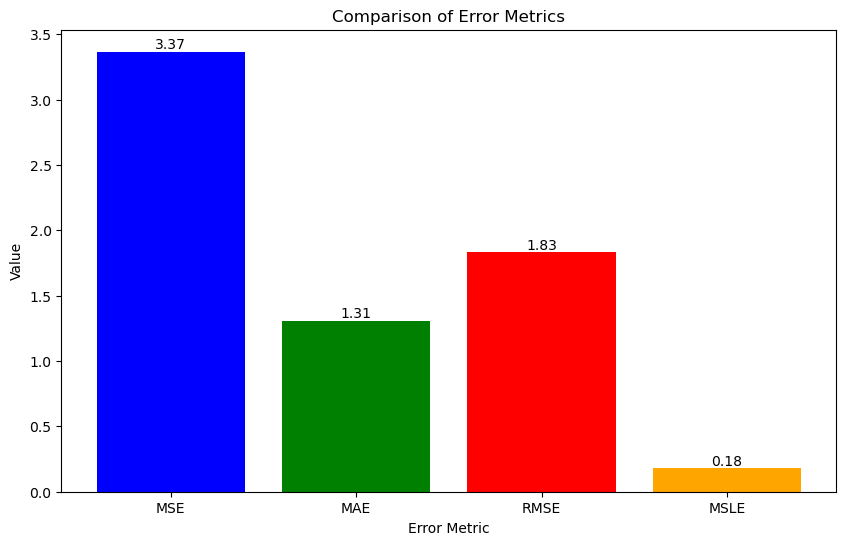

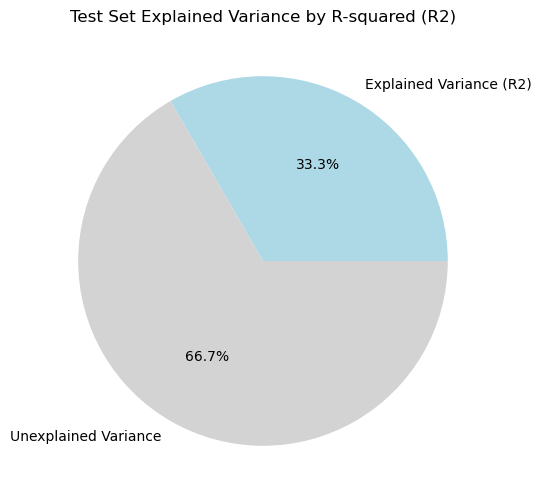

In [10]:
# Metrics calculation
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test, y_test_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.savefig(f'plots/03_metrics/{file_name}_internal.png')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
plt.savefig(f'plots/03_metrics/{file_name}_internal_R2.png')
plt.show()


External Validation Set MSE: 5.3645
External Validation Set MAE: 1.6196
External Validation Set RMSE: 2.3161
External Validation Set R2: -11.9768
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


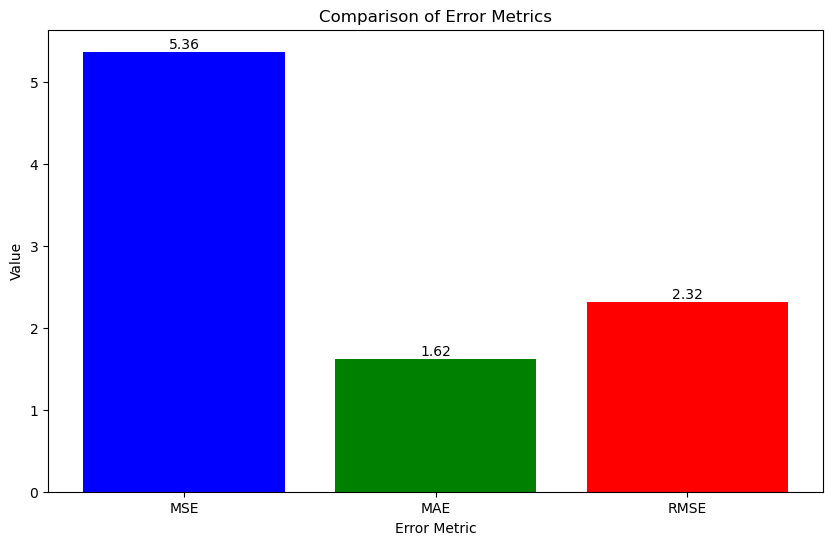

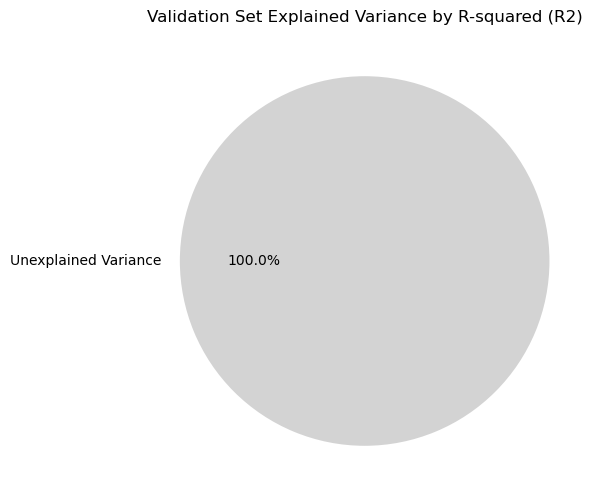

In [11]:
# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_external_pred)
mae_external = mean_absolute_error(y_external, y_external_pred)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_external_pred) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external, y_external_pred)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.savefig(f'plots/03_metrics/{file_name}_external.png')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
plt.savefig(f'plots/03_metrics/{file_name}_external_R2.png')
plt.show()


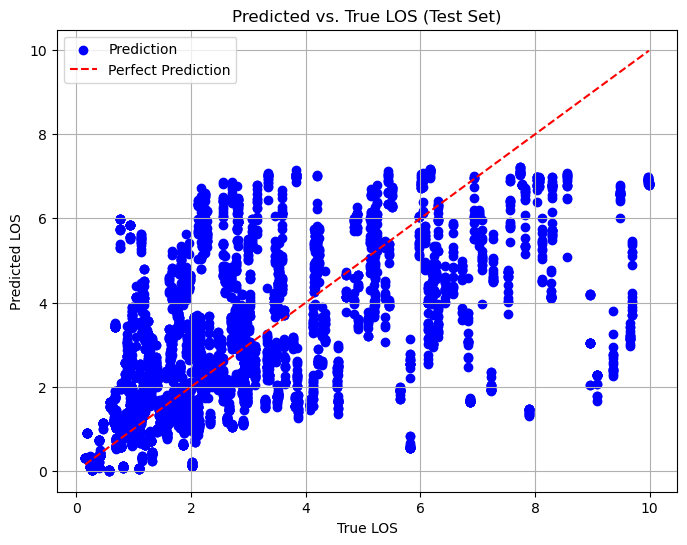

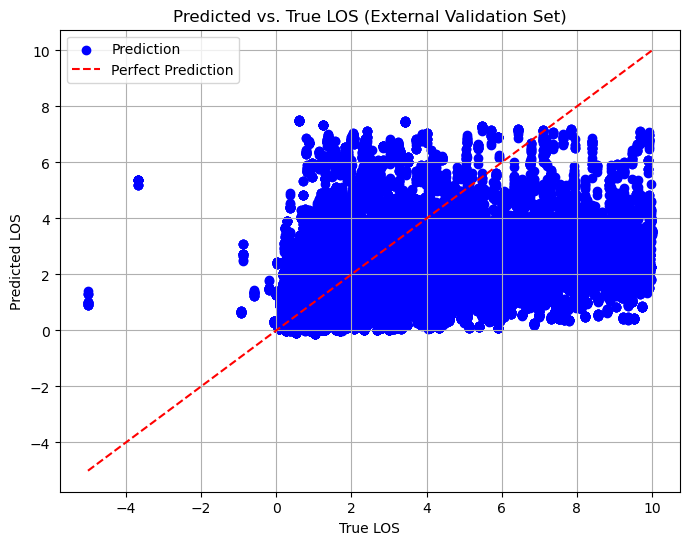

In [12]:
# Test Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Prediction')

# Line for Perfect Prediction
perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (Test Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_test_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# External Validation Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_external, y_external_pred, color='blue', label='Prediction')

# Line for Perfect Prediction (y = x)
perfect_line_ext = np.linspace(y_external.min(), y_external.max(), 100)
plt.plot(perfect_line_ext, perfect_line_ext, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (External Validation Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_external_plot.png", dpi=300, bbox_inches='tight')
plt.show()

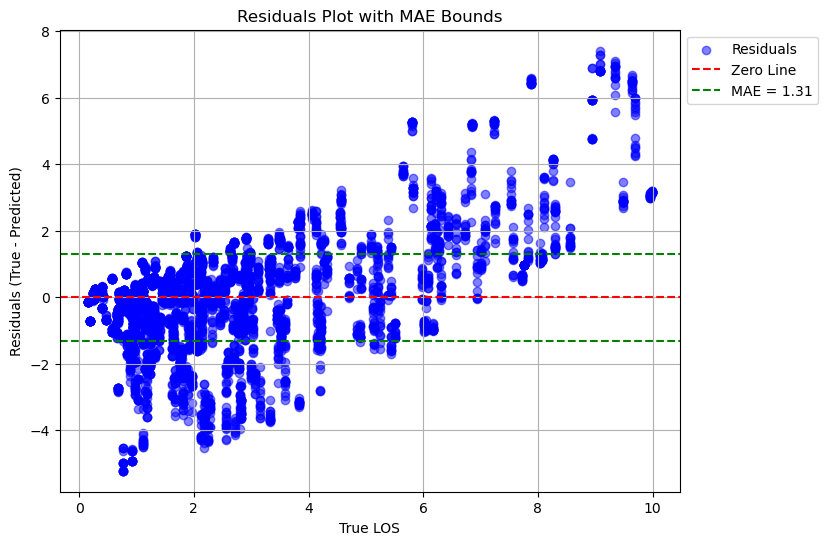

In [13]:
# Convert y_test to a 1D numpy array
y_test = y_test.numpy().flatten()


# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Line")
plt.axhline(y=mae, color='green', linestyle='--', label=f"MAE = {mae:.2f}")
plt.axhline(y=-mae, color='green', linestyle='--')
plt.xlabel('True LOS')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals Plot with MAE Bounds')
plt.grid(True)

# Place the legend outside of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Save the plot as a PNG image
plt.savefig(f"plots/02_Prediction_Plot/01_residuals/{file_name}_residuals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Save model

In [14]:
torch.save(model.state_dict(), f"models/{file_name}.pth")

# Load model

In [ ]:
# Define file
subfolder = "o01_feed_forward.pth"

# Reinitialize the model architecture
input_dim = X_test.shape[1]  # Ensure this matches the original input dimension
model = ANNModel(input_dim)

# Load the saved model state
model.load_state_dict(torch.load(f"models/{subfolder}"))
model.eval()  # Set the model to evaluation mode

"""
After that I must run the block with layers.
Be careful, the layers must be exaclty the same. 
"""